# Process
In this notebook, I will analyse the results of the recommendation.

## A. Import Libraries

In [43]:
import warnings
import pickle as pkl
warnings.simplefilter(action='ignore', category=FutureWarning)
import matplotlib.pyplot as plt
import random as rd
import pandas as pd
import numpy as np
#from run_algorithms import train_algorithms, train_algorithms_kf, prepare_dataset, prepare_dataset_kf
from tqdm import tqdm
import time
pd.set_option("display.precision", 6)
import cornac
from cornac.eval_methods import RatioSplit
from cornac.data import Reader
from cornac.models import MostPop, MF, PMF, BPR, NeuMF, WMF, HPF, VAECF, NMF
from cornac.metrics import MAE, MSE, RMSE, Precision, Recall, NDCG, AUC, MAP, FMeasure, MRR
from collections import defaultdict
from scipy import stats
from numpy.linalg import norm
import seaborn as sns
# set plot style: grey grid in the background:
sns.set(style="darkgrid")

## B. Set Hyperparameters

In [44]:
item_threshold = 5 # remove users with less than item_threshold items
user_threshold = 5 # remove items with less than user_threshold users
top_threshold = 200 # remove users who have rated more than top_threshold items
recommendation_type = "books" # books, music or movies
item_col = "book" # the item column
my_seed = 0 # random_seed
top_fraction_items = 0.2 # the limit for an item to be considered popular
top_fraction_users = 0.2# the limit for a user to be considered High Mainstriminess
split_by = "pop_fraq" # sort users by fraction of popular items (pop_fraq) or by average popularity in profile (pop_item_fraq)
rd.seed(my_seed)
np.random.seed(my_seed)

These additions will be useful so we can load and save the different files (plots and processed data) with clarity on the hyperparameters.

In [45]:
addition_1 = "_u"+str(item_threshold)+"_i"+str(user_threshold)+"_t"+str(top_threshold)
addition_2 = addition_1 + "_tfi"+str(int(100*top_fraction_items))
addition_3 = addition_2 + "_tfu"+str(int(100*top_fraction_users))
addition_4 = addition_3 + ("_sbpf" if (split_by=="pop_fraq") else "_sbpif")

## C. Read Files
Files to read:
1. exp_results & exp_metrics: the Cornac results & metrics
2. training_ids: the user training ids
3. male, female and diverse oriented users

In [46]:
raw_file_location = "data/raw/" # here are stored the raw data files
processed_file_location = "data/processed/" # here we store the processed data files

### Country analysis

In [58]:
USA_oriented_users.head()

,num_USA,num_rest,num_total,ratio_USA,new_ratio_USA_Random,new_ratio_USA_MostPop,new_ratio_USA_UserKNN,new_ratio_USA_MF,new_ratio_USA_PMF,new_ratio_USA_BPR,new_ratio_USA_NMF,new_ratio_USA_WMF,new_ratio_USA_PF,new_ratio_USA_NeuMF,new_ratio_USA_VAECF
226553,23,2,25,0.920000,0.6,0.8,1.0,0.7,0.9,0.8,0.7,0.9,1.0,0.7,1.0
68984,23,2,25,0.920000,0.7,0.8,1.0,0.7,1.0,0.8,0.8,1.0,0.8,0.7,1.0
93453,23,2,25,0.920000,0.7,0.8,0.9,0.4,0.8,0.7,0.5,0.7,0.8,0.7,1.0
163804,70,6,76,0.921053,0.6,0.8,1.0,0.5,0.8,0.7,0.6,1.0,0.8,0.7,1.0
264082,47,4,51,0.921569,0.7,0.8,0.9,0.9,0.6,0.7,0.3,1.0,1.0,0.7,1.0


In [59]:
# Cornac results
with open(processed_file_location+recommendation_type+"/experiment_results_cornac"+addition_4+".pkl", "rb") as f:
    exp_results = pkl.load(f)
with open(processed_file_location+recommendation_type+"/experiment_metrics_cornac"+addition_4+".pkl", "rb") as f:
    exp_metrics = pkl.load(f)

In [60]:
with open(processed_file_location+recommendation_type+"/training_user_ids"+addition_4+".pkl", "rb") as f:
    training_ids = pkl.load(f)

## D. Analyze Results

In [61]:
algo_names = ['Random', 'MostPop', 'UserKNN', 'MF', 'PMF', 'BPR', 'NMF', 'WMF', 'PF', 'NeuMF', 'VAECF']

In [68]:
i=0
for alg in algo_names:
    print(alg)
    print("USA",np.round(USA_oriented_users["new_ratio_USA_"+alg].mean(),2))
    print("midUSA",np.round(midUSA_oriented_users["new_ratio_USA_"+alg].mean(),2))
    print("notUSA",np.round(notUSA_oriented_users["new_ratio_USA_"+alg].mean(),2))
    
    i+=1

Random
USA 0.68
midUSA 0.69
notUSA 0.68
MostPop
USA 0.8
midUSA 0.8
notUSA 0.8
UserKNN
USA 0.95
midUSA 0.8
notUSA 0.51
MF
USA 0.57
midUSA 0.59
notUSA 0.56
PMF
USA 0.58
midUSA 0.6
notUSA 0.59
BPR
USA 0.73
midUSA 0.73
notUSA 0.73
NMF
USA 0.53
midUSA 0.54
notUSA 0.53
WMF
USA 0.91
midUSA 0.76
notUSA 0.48
PF
USA 0.79
midUSA 0.76
notUSA 0.65
NeuMF
USA 0.7
midUSA 0.7
notUSA 0.7
VAECF
USA 0.89
midUSA 0.8
notUSA 0.55


### D.2. Profile USA ratio vs Recommendation USA Ratio

In [54]:
new_avg_USA_oriented = []
new_avg_midUSA_oriented = []
new_avg_notUSA_oriented = []


old_avg_USA_oriented = USA_oriented_users.ratio_USA.mean()
old_avg_midUSA_oriented = midUSA_oriented_users.ratio_USA.mean()
old_avg_notUSA_oriented = notUSA_oriented_users.ratio_USA.mean()

for alg in algo_names:
    mean_notUSA = notUSA_oriented_users["new_ratio_USA_"+alg].mean()
    mean_midUSA = midUSA_oriented_users["new_ratio_USA_"+alg].mean()
    mean_USA = USA_oriented_users["new_ratio_USA_"+alg].mean()
    
    new_avg_notUSA_oriented.append((mean_notUSA - old_avg_notUSA_oriented)/mean_notUSA)
    new_avg_USA_oriented.append((mean_USA - old_avg_USA_oriented)/mean_USA)
    new_avg_midUSA_oriented.append((mean_midUSA - old_avg_midUSA_oriented)/mean_midUSA)

Random -0.4473241171123984
MostPop -0.23853168355101234
UserKNN -0.040820745876192686
MF -0.7350355743137066
PMF -0.7096172560790582
BPR -0.3557765072950403
NMF -0.8550630573763288
WMF -0.09223489139568823
PF -0.2477277904974633
NeuMF -0.41546478120109426
VAECF -0.11199033102301441


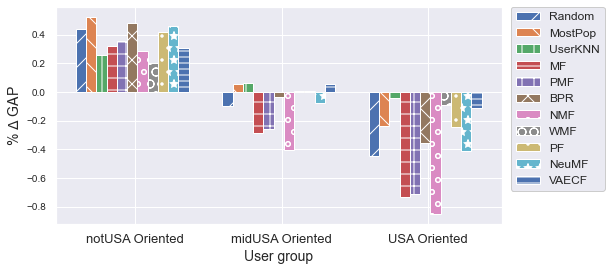

In [55]:
sns.set(rc = {'figure.figsize':(8,4)})

# set width of bar
barWidth = 0.07

# set height of bar
bars1 = [new_avg_notUSA_oriented[0], new_avg_midUSA_oriented[0], new_avg_USA_oriented[0]]
bars2 = [new_avg_notUSA_oriented[1], new_avg_midUSA_oriented[1], new_avg_USA_oriented[1]]
bars3 = [new_avg_notUSA_oriented[2], new_avg_midUSA_oriented[2], new_avg_USA_oriented[2]]
bars4 = [new_avg_notUSA_oriented[3], new_avg_midUSA_oriented[3], new_avg_USA_oriented[3]]
bars5 = [new_avg_notUSA_oriented[4], new_avg_midUSA_oriented[4], new_avg_USA_oriented[4]]
bars6 = [new_avg_notUSA_oriented[5], new_avg_midUSA_oriented[5], new_avg_USA_oriented[5]]
bars7 = [new_avg_notUSA_oriented[6], new_avg_midUSA_oriented[6], new_avg_USA_oriented[6]]
bars8 = [new_avg_notUSA_oriented[7], new_avg_midUSA_oriented[7], new_avg_USA_oriented[7]]
bars9 = [new_avg_notUSA_oriented[8], new_avg_midUSA_oriented[8], new_avg_USA_oriented[8]]
bars10 = [new_avg_notUSA_oriented[9], new_avg_midUSA_oriented[9], new_avg_USA_oriented[9]]
bars11 = [new_avg_notUSA_oriented[10], new_avg_midUSA_oriented[10], new_avg_USA_oriented[10]]

# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]
r5 = [x + barWidth for x in r4]
r6 = [x + barWidth for x in r5]
r7 = [x + barWidth for x in r6]
r8 = [x + barWidth for x in r7]
r9 = [x + barWidth for x in r8]
r10 = [x + barWidth for x in r9]
r11 = [x + barWidth for x in r10]
# r12 = [x + barWidth for x in r11]
# r13 = [x + barWidth for x in r12]

# ['Random', 'MostPop', 'UserKNN', 'MF', 'PMF', 'BPR', 'NMF', 'WMF', 'PF', 'NeuMF', 'VAECF']
patterns = [ "/" , "\\" , "|" , "-" , "+" , "x", "o", "O", ".", "*", "--"]

# Make the plot
plt.bar(r1, bars1, width=barWidth, label='Random', hatch=patterns[0])
plt.bar(r2, bars2, width=barWidth, label='MostPop', hatch=patterns[1])
plt.bar(r3, bars3, width=barWidth, label='UserKNN', hatch=patterns[2])
plt.bar(r4, bars4, width=barWidth, label='MF', hatch=patterns[3])
plt.bar(r5, bars5, width=barWidth, label='PMF', hatch=patterns[4])
plt.bar(r6, bars6, width=barWidth, label='BPR', hatch=patterns[5])
plt.bar(r7, bars7, width=barWidth, label='NMF', hatch=patterns[6])
plt.bar(r8, bars8, width=barWidth, label='WMF', hatch=patterns[7])
plt.bar(r9, bars9, width=barWidth, label='PF', hatch=patterns[8])
plt.bar(r10, bars10, width=barWidth, label='NeuMF', hatch=patterns[9])
plt.bar(r11, bars11, width=barWidth, label='VAECF', hatch=patterns[10])

# Add xticks on the middle of the group bars + show legend
plt.xlabel('User group', fontsize='14')
plt.ylabel('% $\Delta$ GAP', fontsize='14')
plt.xticks([r + barWidth + 0.3 for r in range(len(bars1))], ['notUSA Oriented', 'midUSA Oriented', 'USA Oriented'], fontsize='13')
plt.yticks(fontsize='10')
plt.legend(bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0., framealpha=1, fontsize='12')
plt.show()
#plt.savefig('gap_analysis.pdf', dpi=300, bbox_inches='tight')

In [36]:
for alg in algo_names:
    USA_oriented_users["new_ratio_USA_"+alg] = (USA_oriented_users["new_ratio_USA_"+alg] - USA_oriented_users.ratio_USA)
    midUSA_oriented_users["new_ratio_USA_"+alg] = (midUSA_oriented_users["new_ratio_USA_"+alg] - midUSA_oriented_users.ratio_USA)         
    notUSA_oriented_users["new_ratio_USA_"+alg] = (notUSA_oriented_users["new_ratio_USA_"+alg] - notUSA_oriented_users.ratio_USA)    
    

In [37]:
new_avg_USA_oriented = []
new_avg_midUSA_oriented = []
new_avg_notUSA_oriented = []

for alg in algo_names:
    new_avg_notUSA_oriented.append(notUSA_oriented_users["new_ratio_USA_"+alg].mean())
    new_avg_USA_oriented.append(USA_oriented_users["new_ratio_USA_"+alg].mean())
    new_avg_midUSA_oriented.append(midUSA_oriented_users["new_ratio_USA_"+alg].mean())

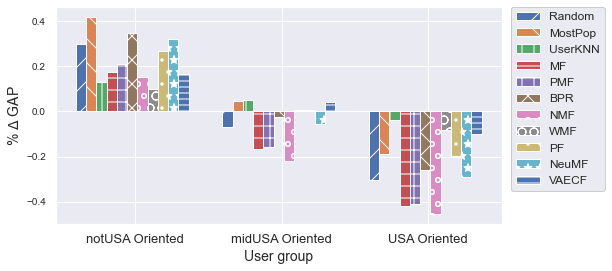

In [38]:
sns.set(rc = {'figure.figsize':(8,4)})

# set width of bar
barWidth = 0.07

# set height of bar
bars1 = [new_avg_notUSA_oriented[0], new_avg_midUSA_oriented[0], new_avg_USA_oriented[0]]
bars2 = [new_avg_notUSA_oriented[1], new_avg_midUSA_oriented[1], new_avg_USA_oriented[1]]
bars3 = [new_avg_notUSA_oriented[2], new_avg_midUSA_oriented[2], new_avg_USA_oriented[2]]
bars4 = [new_avg_notUSA_oriented[3], new_avg_midUSA_oriented[3], new_avg_USA_oriented[3]]
bars5 = [new_avg_notUSA_oriented[4], new_avg_midUSA_oriented[4], new_avg_USA_oriented[4]]
bars6 = [new_avg_notUSA_oriented[5], new_avg_midUSA_oriented[5], new_avg_USA_oriented[5]]
bars7 = [new_avg_notUSA_oriented[6], new_avg_midUSA_oriented[6], new_avg_USA_oriented[6]]
bars8 = [new_avg_notUSA_oriented[7], new_avg_midUSA_oriented[7], new_avg_USA_oriented[7]]
bars9 = [new_avg_notUSA_oriented[8], new_avg_midUSA_oriented[8], new_avg_USA_oriented[8]]
bars10 = [new_avg_notUSA_oriented[9], new_avg_midUSA_oriented[9], new_avg_USA_oriented[9]]
bars11 = [new_avg_notUSA_oriented[10], new_avg_midUSA_oriented[10], new_avg_USA_oriented[10]]

# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]
r5 = [x + barWidth for x in r4]
r6 = [x + barWidth for x in r5]
r7 = [x + barWidth for x in r6]
r8 = [x + barWidth for x in r7]
r9 = [x + barWidth for x in r8]
r10 = [x + barWidth for x in r9]
r11 = [x + barWidth for x in r10]
# r12 = [x + barWidth for x in r11]
# r13 = [x + barWidth for x in r12]

# ['Random', 'MostPop', 'UserKNN', 'MF', 'PMF', 'BPR', 'NMF', 'WMF', 'PF', 'NeuMF', 'VAECF']
patterns = [ "/" , "\\" , "|" , "-" , "+" , "x", "o", "O", ".", "*", "--"]

# Make the plot
plt.bar(r1, bars1, width=barWidth, label='Random', hatch=patterns[0])
plt.bar(r2, bars2, width=barWidth, label='MostPop', hatch=patterns[1])
plt.bar(r3, bars3, width=barWidth, label='UserKNN', hatch=patterns[2])
plt.bar(r4, bars4, width=barWidth, label='MF', hatch=patterns[3])
plt.bar(r5, bars5, width=barWidth, label='PMF', hatch=patterns[4])
plt.bar(r6, bars6, width=barWidth, label='BPR', hatch=patterns[5])
plt.bar(r7, bars7, width=barWidth, label='NMF', hatch=patterns[6])
plt.bar(r8, bars8, width=barWidth, label='WMF', hatch=patterns[7])
plt.bar(r9, bars9, width=barWidth, label='PF', hatch=patterns[8])
plt.bar(r10, bars10, width=barWidth, label='NeuMF', hatch=patterns[9])
plt.bar(r11, bars11, width=barWidth, label='VAECF', hatch=patterns[10])

# Add xticks on the middle of the group bars + show legend
plt.xlabel('User group', fontsize='14')
plt.ylabel('% $\Delta$ GAP', fontsize='14')
plt.xticks([r + barWidth + 0.3 for r in range(len(bars1))], ['notUSA Oriented', 'midUSA Oriented', 'USA Oriented'], fontsize='13')
plt.yticks(fontsize='10')
plt.legend(bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0., framealpha=1, fontsize='12')
plt.show()
#plt.savefig('gap_analysis.pdf', dpi=300, bbox_inches='tight')

In [40]:
USA_oriented_users

,num_USA,num_rest,num_total,ratio_USA,new_ratio_USA_Random,new_ratio_USA_MostPop,new_ratio_USA_UserKNN,new_ratio_USA_MF,new_ratio_USA_PMF,new_ratio_USA_BPR,new_ratio_USA_NMF,new_ratio_USA_WMF,new_ratio_USA_PF,new_ratio_USA_NeuMF,new_ratio_USA_VAECF
226553,23,2,25,0.920000,-0.320000,-0.120000,0.080000,-0.220000,-0.020000,-0.120000,-0.220000,-0.020000,0.080000,-0.220000,0.080000
68984,23,2,25,0.920000,-0.220000,-0.120000,0.080000,-0.220000,0.080000,-0.120000,-0.120000,0.080000,-0.120000,-0.220000,0.080000
93453,23,2,25,0.920000,-0.220000,-0.120000,-0.020000,-0.520000,-0.120000,-0.220000,-0.420000,-0.220000,-0.120000,-0.220000,0.080000
163804,70,6,76,0.921053,-0.321053,-0.121053,0.078947,-0.421053,-0.121053,-0.221053,-0.321053,0.078947,-0.121053,-0.221053,0.078947
264082,47,4,51,0.921569,-0.221569,-0.121569,-0.021569,-0.021569,-0.321569,-0.221569,-0.621569,0.078431,0.078431,-0.221569,0.078431
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
240609,6,0,6,1.000000,-0.300000,-0.200000,0.000000,-0.500000,-0.500000,-0.300000,-0.100000,0.000000,-0.100000,-0.300000,0.000000
41111,9,0,9,1.000000,-0.400000,-0.200000,-0.100000,-0.400000,-0.200000,-0.300000,-0.300000,0.000000,-0.400000,-0.300000,-0.700000
193819,7,0,7,1.000000,-0.600000,-0.200000,0.000000,-0.500000,-0.600000,-0.300000,-0.600000,0.000000,-0.200000,-0.300000,0.000000
193156,5,0,5,1.000000,-0.400000,-0.200000,-0.200000,-0.400000,-0.500000,-0.300000,-0.200000,-0.200000,-0.300000,-0.300000,-0.200000


### D3. Different user groups and metrics

In [41]:
print("User groups evaluation is started ...")

niche_users = list()
divers_users = list()
focused_users = list()

metric_group_results = defaultdict(list)
metric_group_results['MAE'] = list()
metric_group_results['Precision@10'] = list()
metric_group_results['Recall@10'] = list()
metric_group_results['NDCG@10'] = list()

ttest_group_results = defaultdict(list)
ttest_group_results['MAE'] = list()
ttest_group_results['Precision@10'] = list()
ttest_group_results['Recall@10'] = list()
ttest_group_results['NDCG@10'] = list()

for eachresult in exp_results:
    print("> " + eachresult.model_name)
    user_results = eachresult.metric_user_results # <- this is a dictionary
    for metric in exp_metrics:
        for user_idx, user_performance in user_results[metric.name].items():
            user_id = int(training_ids[user_idx])
            if user_id in notUSA_oriented_users.index:
                niche_users.append(user_performance)
            elif user_id in midUSA_oriented_users.index:
                divers_users.append(user_performance)
            elif user_id in USA_oriented_users.index:
                focused_users.append(user_performance)
            else:
                print("Oops! We could not find a user!")

        print(metric.name + ": " + str(round(np.mean(niche_users), 4)) + "," + str(round(np.mean(divers_users), 4)) + "," + str(round(np.mean(focused_users), 4)))
        if metric.name in metric_group_results.keys():
            metric_group_results[metric.name].append((round(np.mean(niche_users), 4),
                                                round(np.mean(divers_users), 4),
                                                round(np.mean(focused_users), 4)))
      
            ttest_group_results[metric.name].append((round(stats.ttest_ind(niche_users, divers_users)[1], 8),
                                               round(stats.ttest_ind(niche_users, focused_users)[1], 8),
                                              round(stats.ttest_ind(divers_users, focused_users)[1], 8)))

        print(stats.ttest_ind(niche_users, focused_users))
        print(len(niche_users)+len(divers_users)+len(focused_users))
        niche_users.clear()
        divers_users.clear()
        focused_users.clear()
    print()

User groups evaluation is started ...
> MostPop
MAE: 2.5334,2.5251,2.4342
Ttest_indResult(statistic=1.4652612868403567, pvalue=0.14300056307375397)
5394
MSE: 10.3065,10.0334,9.4629
Ttest_indResult(statistic=1.8811184838906392, pvalue=0.06009517585810483)
5394
RMSE: 2.7904,2.8295,2.6445
Ttest_indResult(statistic=2.106689263315993, pvalue=0.03526383161416035)
5394
AUC: 0.5985,0.6502,0.6939
Ttest_indResult(statistic=-8.146239236364954, pvalue=6.398213177535995e-16)
5394
MAP: 0.0123,0.0176,0.0111
Ttest_indResult(statistic=0.5163933706555064, pvalue=0.6056345093591763)
5394
MRR: 0.0287,0.0444,0.0213
Ttest_indResult(statistic=1.6736860357305934, pvalue=0.0943424596160453)
5394
Precision@5: 0.0067,0.012,0.0053
Ttest_indResult(statistic=0.8774768510947061, pvalue=0.38032887941120785)
5394
Precision@10: 0.0068,0.0096,0.0038
Ttest_indResult(statistic=2.7583298161436223, pvalue=0.005860512319708315)
5394
Precision@20: 0.0058,0.0078,0.0034
Ttest_indResult(statistic=3.2868820051733136, pvalue=0.001

NDCG@20: 0.0099,0.0069,0.0067
Ttest_indResult(statistic=1.5325049772718888, pvalue=0.125549725214522)
5394
NDCG@50: 0.0163,0.0117,0.0101
Ttest_indResult(statistic=2.6514772402726594, pvalue=0.008074795778461574)
5394
F1@5: 0.0035,0.0026,0.0026
Ttest_indResult(statistic=0.7316557218602897, pvalue=0.46446103085266965)
5394
F1@10: 0.0045,0.0036,0.003
Ttest_indResult(statistic=1.206117762139671, pvalue=0.22790906098945235)
5394
F1@20: 0.0046,0.0038,0.0032
Ttest_indResult(statistic=1.627962455369265, pvalue=0.10368407743775788)
5394
F1@50: 0.0047,0.004,0.0026
Ttest_indResult(statistic=3.5995987408375365, pvalue=0.000326154576405)
5394

> NMF
MAE: 2.2369,2.1926,2.2478
Ttest_indResult(statistic=-0.2380883032050341, pvalue=0.8118360240001214)
5394
MSE: 6.6783,6.6186,6.7901
Ttest_indResult(statistic=-0.45702864570858837, pvalue=0.6476981131386932)
5394
RMSE: 2.374,2.3662,2.3674
Ttest_indResult(statistic=0.14171305341045098, pvalue=0.8873203679167714)
5394
AUC: 0.5701,0.5217,0.4951
Ttest_indResu

Recall@20: 0.04,0.0441,0.0275
Ttest_indResult(statistic=2.0326734948110814, pvalue=0.04221212265147297)
5394
Recall@50: 0.0654,0.0799,0.0643
Ttest_indResult(statistic=0.12928572250579567, pvalue=0.8971440504180636)
5394
NDCG@5: 0.0108,0.0178,0.0081
Ttest_indResult(statistic=0.9242590864490831, pvalue=0.35545849354075365)
5394
NDCG@10: 0.0147,0.0196,0.011
Ttest_indResult(statistic=1.212686689618337, pvalue=0.22538714522302927)
5394
NDCG@20: 0.0205,0.026,0.0143
Ttest_indResult(statistic=1.879100263045608, pvalue=0.06037032278184938)
5394
NDCG@50: 0.027,0.0363,0.0233
Ttest_indResult(statistic=1.053357973168983, pvalue=0.29229912874398584)
5394
F1@5: 0.0076,0.0119,0.0056
Ttest_indResult(statistic=1.0880452632478388, pvalue=0.27670100008000026)
5394
F1@10: 0.0092,0.011,0.006
Ttest_indResult(statistic=2.0612401506231364, pvalue=0.03940398809580916)
5394
F1@20: 0.0096,0.0116,0.0055
Ttest_indResult(statistic=3.53367156593689, pvalue=0.0004187601164004556)
5394
F1@50: 0.007,0.0101,0.0054
Ttest_

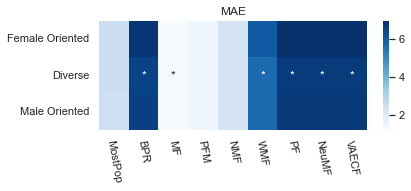

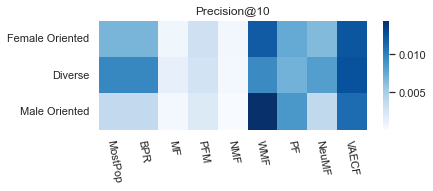

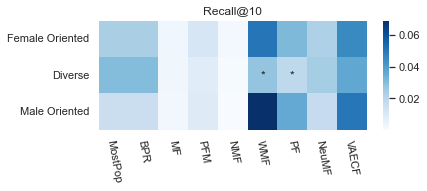

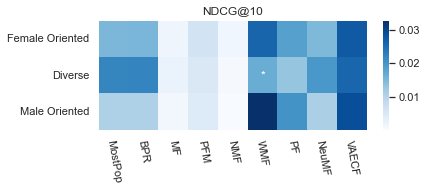

In [42]:
sns.set(rc = {'figure.figsize':(6,2)})

for metric in ['MAE', 'Precision@10', 'Recall@10', 'NDCG@10']:
    data = [[], [], []]
    labels = [['', '', '', '', '', '', '', '', ''], [], []]

    for item in metric_group_results[metric]:
        # print(item)
        data[0].append(item[0])
        data[1].append(item[1])
        data[2].append(item[2])


    for item in ttest_group_results[metric]:
        if item[0] < 0.005:
            labels[1].append('*')
        else:
            labels[1].append('')
        if item[1] < 0.005 and item[2] < 0.005:
            labels[2].append('**')
        else:
            labels[2].append('')

    fig, ax = plt.subplots()
    ax.set_title(metric)
    ax = sns.heatmap(data, annot=labels, fmt = '', cmap="Blues")
    ax.set_xticklabels(['MostPop', 'BPR', 'MF', 'PFM', 'NMF', 'WMF', 'PF', 'NeuMF', 'VAECF'])
    ax.set_yticklabels(['Female Oriented', 'Diverse', 'Male Oriented'])
    ax.tick_params(axis='x', rotation=280)
    ax.tick_params(axis='y', rotation=0)
    #plt.savefig(f'{metric}_metric_analysis.pdf', dpi=300, bbox_inches='tight')